In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.io import imread_collection
from pathlib import Path
import itertools

%matplotlib inline

/Users/kasey/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Deep Drink
Using image inpainting to censor images of alcoholic beverages.

## Pre-processing: Loading Data

In [2]:
num_px = 128

In [60]:
# Load images from the local images folder
# Images downloaded from Open Images using 
# https://github.com/EscVM/OIDv4_ToolKit
def load_images():
    img_dir = 'images/Beer/*.jpg'
    img_col = imread_collection(img_dir)
    final_col = []
    img_files = [x.replace("images/Beer/", "")[:-4] for x in img_col.files]
    for (img, fn) in zip(img_col, img_files):
        img = img/255.
        #img_resize = resize(img, output_shape=(num_px, num_px), mode='constant')
        final_col.append((fn, img))
    return final_col

In [61]:
# Load labels from local labels folder
# Labels downloaded from Open Images using 
# https://github.com/EscVM/OIDv4_ToolKit
def load_labels_dict():
    my_dir = Path('images/Beer/Label/')
    d = {}
    
    for file in my_dir.glob('*.txt'):
        line = file.read_text(encoding='utf-8').split()
        
        for i in range(0, len(line), 5): 
            # label, x-coordinate, y-coordinate, width, height
            (label, x, y, w, h) = line[i:i+5]
            filename = file.stem

            if (file.stem in d):
                d[file.stem].append({'coordinates': {'x': x, 'y': y, 'width': w, 'height': h}})
            else:
                d[file.stem] = [{'coordinates': {'x': x, 'y': y, 'width': w, 'height': h}}] 
    return d

In [89]:
labels = load_labels_dict()

In [90]:
# Load images into a collection
images = load_images()

TypeError: unhashable type: 'numpy.ndarray'

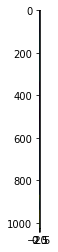

In [150]:
# Example of a picture
index = 2
plt.imshow(images[index][1])
#print(labels)
print(labels[images[index][0]])

In [144]:
my_dir = Path('images/Beer/Label/')

label_lines = [] 
for file in my_dir.glob("*.txt"):
        label_lines.append(file.read_text(encoding='utf-8').split())
        
print(label_lines)

[['Beer', '151.72198400000002', '0.0', '877.003776', '768.0'], ['Beer', '366.032896', '87.539166', '936.66304', '923.0'], ['Beer', '649.9215360000001', '0.42009599999999997', '877.797376', '185.10643199999998', 'Beer', '845.92128', '0.0', '988.1876480000001', '160.995072', 'Beer', '945.375232', '18.04032', '1024.0', '344.134656'], ['Beer', '342.672264', '176.441344', '602.0777840000001', '729.191424'], ['Beer', '155.194368', '0.0', '922.039296', '888.859648'], ['Beer', '88.79232', '30.81216', '398.274048', '991.0906880000001', 'Beer', '421.88083199999994', '50.141184', '660.42624', '1007.121408'], ['Beer', '89.09802', '0.44543999999999995', '352.72620000000006', '915.984384', 'Beer', '405.53262', '158.298112', '730.65609', '935.3103359999999'], ['Beer', '113.4336', '527.1288509999999', '196.53222399999999', '632.515755', 'Beer', '234.21644799999999', '439.145649', '338.573312', '633.0', 'Beer', '609.1264', '382.102221', '698.022912', '633.0', 'Beer', '725.0790400000001', '362.764704000

In [141]:
def load_images_and_labels():
    img_dir = 'images/Beer/*.jpg'
    final_col = []
    
    
    labels = load_labels_dict()     
    img_col = imread_collection(img_dir)
    files = img_col.files

   

    for (img, file, line) in zip(final_col, files, label_lines):
        print(file)
        print(line)
        img = img/255.
        im = Image.open(file)
        img_width, img_height = im.size
        #fn = fn.replace("images/Beer/", "")[:-4]

        for i in range(0, len(line), 5): 
            # label, x-coordinate, y-coordinate, width, height
            (label, x, y, w, h) = line[i:i+5]

            # rescale
#             x = float(x) * num_px / img_width
#             y = float(y) * num_px / img_height
#             w = float(w) / num_px
#             h = float(h) / num_px

            if (file in d):
                d[file].append({'coordinates': {'x': x, 'y': y, 'width': w, 'height': h}})
            else:
                d[file] = [{'coordinates': {'x': x, 'y': y, 'width': w, 'height': h}}] 
                
        
        img_resize = resize(img, output_shape=(num_px, num_px), mode='constant')
        final_col.append((file, img))
        
    return (final_col, d)

In [149]:
images, labels = load_images_and_labels()

In [148]:
def load_images_and_labels():
    img_dir = 'images/Beer/*.jpg'
    my_dir = Path('images/Beer/Label/')
    
    label_lines = [] 
    d = {}
    final_col = []
    
    img_col = imread_collection(img_dir)
    img_files = img_col.files

    for file in my_dir.glob("*txt"):
        label_lines.append(file.read_text(encoding='utf-8').split())
        
        
    for img in img_col:
        final_col.append(img)

    for (img, fn, file) in zip(img_col, img_files, my_dir.glob('*.txt')):
        img = img/255.
        im = Image.open(fn)
        img_width, img_height = im.size
        #fn = fn.replace("images/Beer/", "")[:-4]

        line = file.read_text(encoding='utf-8').split()
        for i in range(0, len(line), 5): 
            # label, x-coordinate, y-coordinate, width, height
            (label, x, y, w, h) = line[i:i+5]

            # rescale
#             x = float(x) * num_px / img_width
#             y = float(y) * num_px / img_height
#             w = float(w) / num_px
#             h = float(h) / num_px

            if (fn in d):
                d[fn].append({'coordinates': {'x': x, 'y': y, 'width': w, 'height': h}})
            else:
                d[fn] = [{'coordinates': {'x': x, 'y': y, 'width': w, 'height': h}}] 
                
        
        img_resize = resize(img, output_shape=(num_px, num_px), mode='constant')
        final_col.append((fn, img))
        
    return (final_col, d)

{'images/Beer/0acfa779589204bf.jpg': [{'coordinates': {'x': '151.72198400000002', 'y': '0.0', 'width': '877.003776', 'height': '768.0'}}], 'images/Beer/0b03c518162a867e.jpg': [{'coordinates': {'x': '366.032896', 'y': '87.539166', 'width': '936.66304', 'height': '923.0'}}], 'images/Beer/1aa3acb3e0b57865.jpg': [{'coordinates': {'x': '649.9215360000001', 'y': '0.42009599999999997', 'width': '877.797376', 'height': '185.10643199999998'}}, {'coordinates': {'x': '845.92128', 'y': '0.0', 'width': '988.1876480000001', 'height': '160.995072'}}, {'coordinates': {'x': '945.375232', 'y': '18.04032', 'width': '1024.0', 'height': '344.134656'}}], 'images/Beer/1b55f9174167a8d3.jpg': [{'coordinates': {'x': '342.672264', 'y': '176.441344', 'width': '602.0777840000001', 'height': '729.191424'}}], 'images/Beer/2c87374e8d2f3a34.jpg': [{'coordinates': {'x': '155.194368', 'y': '0.0', 'width': '922.039296', 'height': '888.859648'}}], 'images/Beer/3ba5380490084697.jpg': [{'coordinates': {'x': '88.79232', 'y':

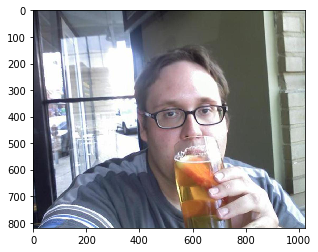

In [153]:
# Example of a picture
index = 2
plt.imshow(images[index])
print(labels)
#print(labels[images[index][0]])